# 利用MindQuantum解决组合优化问题

In [7]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
Looking in links: https://obs-workspace-20180810.obs.cn-north-1.myhuaweicloud.com/pypi/index.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import networkx as nx

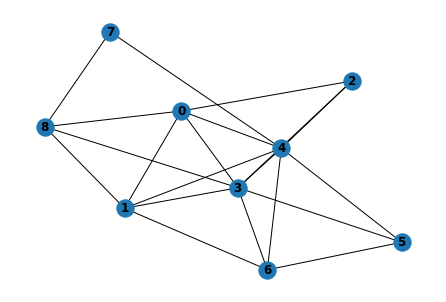

In [2]:
g = nx.gnm_random_graph(9, 20, seed=42)
nx.draw(g,with_labels=True, font_weight='bold')

In [3]:
print(list(g.edges))

[(0, 1), (0, 8), (0, 2), (0, 4), (0, 3), (1, 8), (1, 6), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (3, 8), (3, 6), (3, 5), (4, 7), (4, 5), (4, 6), (5, 6), (7, 8)]


## nx库中的解法

In [4]:
cut, partition = nx.algorithms.approximation.one_exchange(g)
print(cut, partition)

14 ({8, 3, 4}, {0, 1, 2, 5, 6, 7})


## Try to solve by yourself

In [5]:
def solution(edges):
    pass

In [6]:
my_cut = solution(list(g.edges))
print(f'I get {my_cut} cuts')

I get None cuts


## QAOA

In [8]:
from mindquantum import *

In [1]:
depth = 2
ansatz = MaxCutAnsatz(list(g.edges), depth)

ham = ansatz.hamiltonian
circuit = ansatz.circuit
circuit

NameError: name 'MaxCutAnsatz' is not defined

In [10]:
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(-ham), circuit)

In [11]:
import numpy as np

grad_ops(np.random.random(size=len(circuit.params_name)))

(array([[-10.03899673+3.4861374e-17j]]),
 array([[[ 0.04576657+0.j, -0.00659024+0.j]]]))

### 利用`scipy`的优化器进行优化

In [12]:
from scipy.optimize import minimize

def fun(x):
    f, g = grad_ops(x)
    print(f"Cut value: {-f.real[0, 0]}")
    return f.real[0, 0], g.real[0, 0]

np.random.seed(1)
x0 = np.random.random(len(circuit.params_name))
optimizers = ['cg', 'COBYLA', 'Powell', 'bfgs']
opti = optimizers[0]
tol = 4e-1
res = minimize(fun, x0, method=opti, jac=True, tol=tol)

Cut value: 7.571326575273142
Cut value: 8.798041290493835
Cut value: 10.270515403328357
Cut value: 10.853664731765702
Cut value: 9.750983042440836
Cut value: 10.24068617225065
Cut value: 10.895373273967309
Cut value: 10.958835300494815
Cut value: 10.978826727914933
Cut value: 10.077157328732397
Cut value: 10.979958324452262


In [13]:
def get_partitions(theta, first_n=1):
    s = Simulator('projectq', circuit.n_qubits)
    s.apply_circuit(circuit, dict(zip(circuit.params_name, theta)))
    state = s.get_qs()
    amp = np.abs(state)**2
    partitions=[]
    for n in range(first_n):
        poi = np.argmax(amp)
        amp[poi] = -1
        bin_string = bin(poi)[2:].zfill(circuit.n_qubits)[::-1]
        partition = [[], []]
        for i, j in enumerate(bin_string):
            partition[int(j)].append(i)
        partitions.append(partition)
    return partitions

def get_cut_value(graph, partitions):
    values = []
    for partition in partitions:
        value = 0
        for p0 in partition[0]:
            for p1 in partition[1]:
                for g in graph:
                    if p0 in g and p1 in g:
                        value += 1
        values.append(value)
    return values

In [14]:
partitions = get_partitions(res.x, 6)
for i, j in enumerate(partitions):
    print(f'partition {i}: {j}')

partition 0: [[3, 4, 6, 7, 8], [0, 1, 2, 5]]
partition 1: [[0, 1, 2, 5], [3, 4, 6, 7, 8]]
partition 2: [[0, 3, 4], [1, 2, 5, 6, 7, 8]]
partition 3: [[1, 2, 5, 6, 7, 8], [0, 3, 4]]
partition 4: [[3, 4, 7, 8], [0, 1, 2, 5, 6]]
partition 5: [[0, 1, 2, 5, 6], [3, 4, 7, 8]]


In [15]:
cut_values = get_cut_value(g.edges, partitions)
print(f'cut values: {cut_values}')
print(f'\nYour configuration:\ndepth: {depth}\nmethod: {opti}\ntol: {tol}\nstep: {res.nfev}')

cut values: [12, 12, 13, 13, 12, 12]

Your configuration:
depth: 1
method: cg
tol: 0.1
step: 11
